<a href="https://colab.research.google.com/github/Calaria/pytorch_models/blob/main/multi_class_exercise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

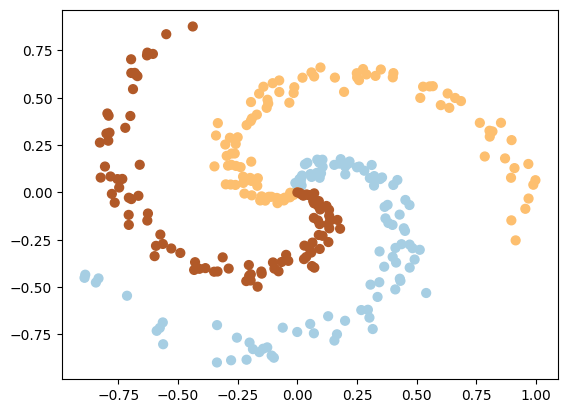

In [107]:
import matplotlib.pyplot as plt
import numpy as np
N=100
D=2
K=3
X=np.zeros((N*K,D))
y=np.zeros(N*K,dtype='uint8')
for j in range(K):
  ix=range(N*j,N*(j+1))
  r=np.linspace(0.0,1,N)
  t=np.linspace(j*4,(j+1)*4,N)+np.random.randn(N)*0.2
  X[ix]=np.c_[r*np.sin(t),r*np.cos(t)]
  y[ix]=j
plt.scatter(X[:, 0], X[:, 1], c=y,s=40, cmap=plt.cm.Paired)
plt.show()


In [108]:
import torch
#Preprocess data
#Turn data into tensor
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.LongTensor)
#S
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [109]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [110]:
NUM_FEATURES=D
NUM_CLASSES=K
hidden_units=8

In [111]:
from torch import nn
class Spiral(nn.Module):
    def __init__(self,input_features,output_features,hidden_units=8):
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),
        )
    def forward(self, x):
      return self.linear_layer_stack(x)
model_0=Spiral(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=hidden_units).to(device)
model_0

Spiral(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=3, bias=True)
  )
)

In [112]:
#Loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_0.parameters(),
                           lr=0.1)


In [113]:
model_0(X.to(device))[:5]

tensor([[-0.0731, -0.1842, -0.4631],
        [-0.0736, -0.1839, -0.4631],
        [-0.0737, -0.1838, -0.4629],
        [-0.0739, -0.1836, -0.4628],
        [-0.0735, -0.1838, -0.4623]], device='cuda:0',
       grad_fn=<SliceBackward0>)

In [114]:
# Make prediction logits with model
y_logits = model_0(X_test.to(device))

# Perform softmax calculation
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])
torch.sum(y_pred_probs[0])

tensor([[-0.0711, -0.1854, -0.4618],
        [-0.1093, -0.1701, -0.4875],
        [-0.0906, -0.1731, -0.4607],
        [-0.0751, -0.1827, -0.4619],
        [-0.0743, -0.1914, -0.4660]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.3893, 0.3473, 0.2634],
        [0.3808, 0.3583, 0.2609],
        [0.3829, 0.3526, 0.2645],
        [0.3880, 0.3484, 0.2635],
        [0.3898, 0.3467, 0.2635]], device='cuda:0', grad_fn=<SliceBackward0>)


tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [115]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.3893, 0.3473, 0.2634], device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0, device='cuda:0')


In [116]:
#Def accuracy_function

def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [117]:
#Preparation
torch.manual_seed(42)
epochs=3000

#Put data to target device
X_train,y_train=X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device), y_test.to(device)

In [118]:
#traing the model
for epoch in range(epochs):
  #training
  model_0.train()

  #1.Forward pass
  y_logits = model_0(X_train)
  y_pred=torch.softmax(y_logits,dim=1).argmax(dim=1)

  #2.Calculate loss and accuracy
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  #3.Optimizer zero grad
  optimizer.zero_grad()

  #4.Loss backwards
  loss.backward()

  #5.Step
  optimizer.step()

  ###Testing
  model_0.eval()
  with torch.inference_mode():
    #1.Forward pass
    test_logits = model_0(X_test)
    test_pred=torch.softmax(test_logits,dim=1).argmax(dim=1)
    #2.Calculate test loss and accuracy
    test_loss = loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_true=y_test,
                         y_pred=test_pred)

    #Printing
    if epoch %100 ==0:
      print(f"Epoch: {epoch} Loss :{loss:.5f}, Acc:{acc:.2f}%| Test Loss: {test_loss:.5f}, Test Acc:{test_acc:.2f}%")

Epoch: 0 Loss :1.11155, Acc:32.50%| Test Loss: 1.11680, Test Acc:36.67%
Epoch: 100 Loss :1.04352, Acc:55.00%| Test Loss: 1.04965, Test Acc:46.67%
Epoch: 200 Loss :0.90431, Acc:60.00%| Test Loss: 0.91044, Test Acc:53.33%
Epoch: 300 Loss :0.78299, Acc:56.25%| Test Loss: 0.79888, Test Acc:50.00%
Epoch: 400 Loss :0.71773, Acc:55.42%| Test Loss: 0.74861, Test Acc:48.33%
Epoch: 500 Loss :0.67348, Acc:61.67%| Test Loss: 0.71273, Test Acc:51.67%
Epoch: 600 Loss :0.62488, Acc:66.25%| Test Loss: 0.67068, Test Acc:53.33%
Epoch: 700 Loss :0.56614, Acc:71.25%| Test Loss: 0.61502, Test Acc:55.00%
Epoch: 800 Loss :0.51515, Acc:74.58%| Test Loss: 0.56611, Test Acc:60.00%
Epoch: 900 Loss :0.47848, Acc:77.92%| Test Loss: 0.53130, Test Acc:68.33%
Epoch: 1000 Loss :0.45251, Acc:79.58%| Test Loss: 0.50626, Test Acc:68.33%
Epoch: 1100 Loss :0.43263, Acc:80.83%| Test Loss: 0.48427, Test Acc:70.00%
Epoch: 1200 Loss :0.41487, Acc:82.50%| Test Loss: 0.46906, Test Acc:71.67%
Epoch: 1300 Loss :0.39583, Acc:83.33%

In [119]:
model_0.eval()
with torch.inference_mode():
  y_logits = model_0(X_test)
#Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits,dim=1)
y_preds = y_pred_probs.argmax(dim=1)
print(f"Predictions: {y_preds[:10]}\nLabels: {y_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_test, y_pred=y_preds)}%")

Predictions: tensor([2, 2, 1, 0, 2, 2, 1, 1, 0, 1], device='cuda:0')
Labels: tensor([2, 2, 1, 0, 2, 2, 1, 1, 0, 1], device='cuda:0')
Test accuracy: 100.0%


In [120]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)
from helper_functions import plot_predictions, plot_decision_boundary



helper_functions.py already exists, skipping download


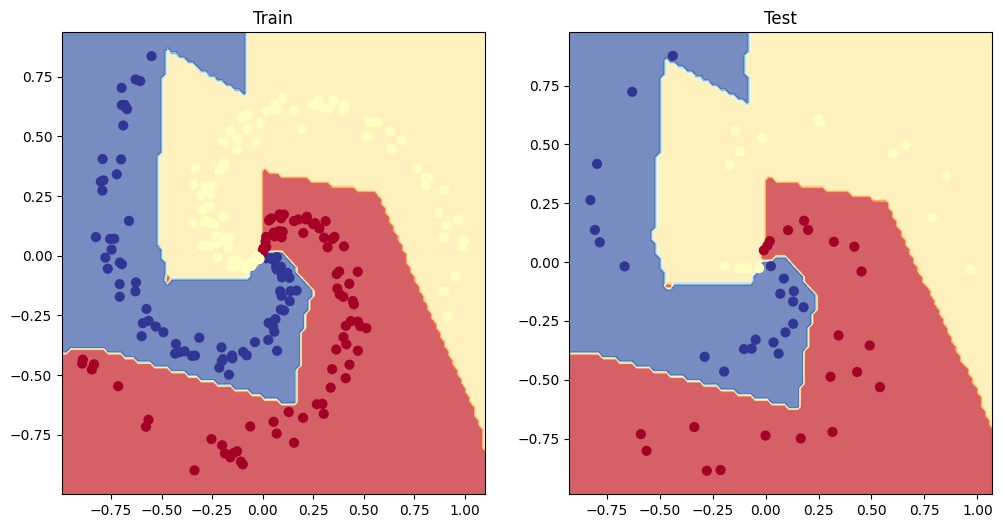

In [121]:
plt.figure(figsize = (12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_0, X_train,y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_0,X_test, y_test)


In [129]:
try:
  from torchmetrics import Accuracy
except:
  !pip install torchmetrics==0.9.3
  from torchmetrics import Accuracy
torchmetrics_accuracy = Accuracy(task="multicalss",num_classes=4).to(device)

torchmetrics_accuracy(y_preds,y_test)

tensor(1., device='cuda:0')